# Projeto #1 - Classificação

<p style='text-align: justify;'><font size=3.>Análise de acidentes nas rodovias federais brasileira entre 2007 e 2021.</font></p>

### Bibliotecas básicas e outros imports

In [2]:
import random
import warnings
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score

%run modules/text.py
%matplotlib inline
plt.rcParams['font.family'] = 'Arial, Helvetica, sans-serif'

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
np.set_printoptions(suppress=True, precision=3)

### Carregamento dos dados

In [3]:
df = pd.read_csv('dataset/classifier_acidentes_rodovias_brasileiras_2007_a_2021.csv', low_memory=False, encoding='utf-8')
print(f'Linhas: {df.shape[0]} | Coluna:  {df.shape[1]}')

Linhas: 1674465 | Coluna:  30


### Seleção dos dados para o estado MG

In [4]:
acidentes_minas = df.query('uf=="MG"').reset_index(drop=True)
acidentes_minas.rename(columns={'classificacao_acidente': 'classe'}, inplace=True)
print(f'Linhas: {acidentes_minas.shape[0]} | Coluna:  {acidentes_minas.shape[1]}')
acidentes_minas.head(1)

Linhas: 247397 | Coluna:  30


,id,dia_semana,uf,br,km,municipio,causa_acidente,tipo_acidente,classe,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,tipo_veiculo,tipo_envolvido,estado_fisico,idade,sexo,data,mes,ano,feriado,faixa_etaria,porte_veiculo,condicao_clima,estacao_do_ano,regiao_pais,feriado_agrupado
0,83123235.0,quarta,MG,381,491.0,Betim,falta de atencao,colisao traseira,sem vitimas,plena noite,crescente,nublado,dupla,reta,urbano,automovel,condutor,ileso,24,masculino,2014-01-01,1,2014,ano novo,jovem,pequeno porte,nublado,verão,sudeste,feriado


### Contagem dos dados

In [5]:
print('Proporção de dados na base:')
print((acidentes_minas['classe'].value_counts(normalize=True)*100).round(1))

Proporção de dados na base:
sem vitimas            51.8
com vitimas feridas    44.1
com vitimas fatais      4.1
Name: classe, dtype: float64


### Seleção de features

In [6]:
colunas = [
    'dia_semana',
    'fase_dia',
    'tipo_pista',
    'sentido_via',
    'tracado_via',
    'condicao_metereologica',
    'tipo_acidente',
    'tipo_veiculo',
    'br',
    'km',
    'sexo',
    'faixa_etaria',
    'classe'
]
dados = acidentes_minas[colunas]
dados.head(1)

,dia_semana,fase_dia,tipo_pista,sentido_via,tracado_via,condicao_metereologica,tipo_acidente,tipo_veiculo,br,km,sexo,faixa_etaria,classe
0,quarta,plena noite,dupla,crescente,reta,nublado,colisao traseira,automovel,381,491.0,masculino,jovem,sem vitimas


### Separação dos dados

In [7]:
X = dados.drop(['classe'], axis=1)
y = dados['classe']

### Label encoder

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)

### Vetorização dos dados categóricos

In [9]:
encoder = LabelEncoder()
for col in X.columns:
    if col != 'br' and col!='km':
        X[col] = encoder.fit_transform(X[col].astype(str))

### Balanceamento da base

In [10]:
smote = SMOTE(random_state=32)
X_smote_res, y_smote_res = smote.fit_resample(X, y)
print(len(X_smote_res))

384504


### Divisão treino e teste

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_smote_res, y_smote_res, test_size=0.3, shuffle=True)
print(f'Shape treino: {X_train.shape[0]} | Shape teste: {X_test.shape[0]}')

Shape treino: 269152 | Shape teste: 115352


### Testando famílias de algoritmos

In [11]:
estimators = [
    RandomForestClassifier(n_estimators=700, max_depth=3),
    ExtraTreesClassifier(n_estimators=700, max_depth=3),
    KNeighborsClassifier(n_neighbors=10),
    XGBClassifier(learning_rate=0.5, max_depth=4, min_child_weight=8, nthread=1, subsample=0.8),   
    MLPClassifier(hidden_layer_sizes=[512, 256, 128], activation='relu', solver='adam', alpha=1e-5, max_iter=35, batch_size=100, shuffle=True, verbose=False)
]

for clf in estimators:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'Resultado para o classificador {clf}')
    print(accuracy_score(y_test, y_pred))
    print('----------------------------------------------')

Resultado para o classificador RandomForestClassifier(max_depth=3, n_estimators=700)
0.578654899785006
----------------------------------------------
Resultado para o classificador ExtraTreesClassifier(max_depth=3, n_estimators=700)
0.5543033497468618
----------------------------------------------
Resultado para o classificador KNeighborsClassifier(n_neighbors=10)
0.656000762882308
----------------------------------------------
Resultado para o classificador XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.5, max_delta_step=0, max_depth=4,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=No

### Teste pareado Student’s t-test 
> Para comparação do desempenho dos modelos de ML


**H0**: Não há diferença entre o desempenho dos dois modelos

**H1**: Há diferença entre o desempenho dos dois modelos

In [ ]:
clf_mlp = MLPClassifier(hidden_layer_sizes=[512, 256, 128], max_iter=35, activation='relu', solver='adam', alpha=1e-5, batch_size=100, shuffle=True, verbose=False)
clf_xgb = XGBClassifier(learning_rate=0.5, max_depth=4, min_child_weight=8, nthread=1, subsample=0.8)

XGB_score, RF_score = [], []

for i in range(10):
    print(f'Iniciando idx: {i}')
    random_state = random.randint(42, 950)
    print(f'Random state: {random_state}')
    
    X_train, X_test, y_train, y_test = train_test_split(X_smote_res, 
                                                        y_smote_res, 
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=random_state)
    
    scores_mlp = cross_val_score(clf_mlp, X, y, cv=5, scoring='accuracy', verbose=False, n_jobs=2)
    RF_score.append(scores_mlp.mean())
    scores_xgb = cross_val_score(clf_xgb, X, y, cv=5, scoring='accuracy', verbose=False, n_jobs=2)
    XGB_score.append(scores_xgb.mean())

Comparando o desempenho

In [ ]:
alpha = 0.05
_, p_value = stats.ttest_rel(XGB_score, MLP_score)
print(f'Teste pareado Student’s t-test: {p_value}')

if p_value < alpha:
    print(f'Rejeita H0. Temos evidências estatísticas de que a floresta aleatória e o XGB têm desempenho diferente.')
else:
    print(f'Não rejeita H0. Não há diferença de desempenho entre os modelos.')

### Modelagem dos dados

Modelo

In [12]:
clf = XGBClassifier(learning_rate=0.5, max_depth=4, min_child_weight=8, nthread=1, subsample=0.8)

Validação cruzada

In [13]:
scores = cross_val_score(clf, X_smote_res, y_smote_res, cv=5, scoring='accuracy', verbose=True, n_jobs=2)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy: 0.69 (+/- 0.06)


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.6min finished


Relatório de classificação

In [14]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_.tolist()))

                     precision    recall  f1-score   support

 com vitimas fatais       0.81      0.82      0.82     38336
com vitimas feridas       0.65      0.51      0.57     38465
        sem vitimas       0.66      0.79      0.72     38551

           accuracy                           0.71    115352
          macro avg       0.71      0.71      0.70    115352
       weighted avg       0.71      0.71      0.70    115352



Matriz de confusão

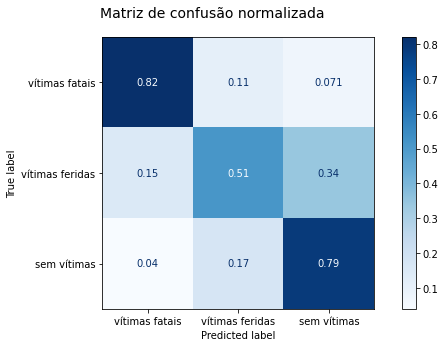

In [15]:
labels = ['vítimas fatais', 'vítimas feridas', 'sem vítimas']
np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = [10, 5]
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=labels,
                                 cmap=plt.cm.Blues,
                                 normalize='true'
                                 )
disp.ax_.set_title('Matriz de confusão normalizada', fontsize=14, y=1.05, loc='left', x=-0.01)
plt.grid(False)
plt.savefig('matriz_confusao_acidentes_minas_gerais.png')
plt.show()